In [1]:
using Random
using LinearAlgebra
using Statistics
using Plots
import Base.isless

using Cxx, Libdl

In [2]:
const path_to_lib = pwd()
addHeaderDir(path_to_lib*"/world/", kind=C_System)
cxxinclude("runWorld.h")

In [62]:
mutable struct Bird
    genes::Array{Float64}
    fitness::Float64
end

function Bird(;dim=5)
    genes = randn(dim)
    fitness = 0.0
    Bird(genes, fitness)
end 

function isless(b1::Bird, b2::Bird)
    b1.fitness < b2.fitness
end

isless (generic function with 45 methods)

In [63]:
#test
flappy = Bird()
println(flappy)

Bird([0.4124500786493836, -0.921293596136804, -1.092395676643405, -1.2897809930514752, 1.359567941628257], 0.0)


In [243]:
cxx"""

static double evaluate_bird(float g1, float g2, float g3, float g4, float g5) {
float ind[5] = {g1,g2,g3,g4,g5};

	const int NRUN = 3;
	auto &g = ind;
	double d = 0;
	for (int r = 0; r < NRUN; ++r) {
		World world;
		world.gen.seed(r * 100);
		while (world.bestiau.vivant) {

            world.update();
            // update inputs
            float birdY = world.bestiau.y;
            float birdVY = world.bestiau.vit;
            float obsX;
            float obsY;
            if (world.obstacles.size() > 0) {
                const auto &o = world.obstacles.front();
                obsY = o.y + world.hauteurPassage * 0.5;
                obsX = o.x / world.W;
            } else {
                obsY = world.H * 0.5;
                obsX = 1000.0;
            }
            double dd = world.dist;
            //if ((g[0]*birdY+g[1]*birdVY+g[2]*obsX+g[3]*obsY)>1.0) world.bestiauUp();
            //if ((g[0]*(birdY-obsY)+g[1]*birdY+g[2]*obsX+g[3]*birdVY)>1.0) world.bestiauUp();
            //if ((g[0]*(birdY-obsY)+g[1]*birdY+g[2]*obsX+g[3]*birdVY+g[4]*dd)>1.0) world.bestiauUp();
            if ((g[0]*(birdY-obsY)+g[1]*birdY+g[2]*obsX+g[3]*birdVY+g[4]*world.vitesseDefilement)>1.0) world.bestiauUp();
        }
        d += world.dist;
        d -= 0.001*abs(world.bestiau.y-world.obstacles.front().y);
    }
    return d;
}
"""

true

In [244]:
cpptojulia(g1::Float64, g2::Float64, g3::Float64, g4::Float64, g5::Float64) = @cxx evaluate_bird(g1,g2,g3,g4,g5)
function evaluate_bird(g::Array{Float64})
    cpptojulia(g[1],g[2],g[3],g[4],g[5])
end

evaluate_bird (generic function with 1 method)

In [245]:
function evaluate!(flappy::Bird)
    g=flappy.genes
    flappy.fitness = evaluate_bird(g)
end

evaluate! (generic function with 1 method)

In [64]:
# test

flappy = Bird()
println(flappy)
g = flappy.genes
ev = evaluate_bird(g)
println(ev)
evaluate!(flappy)
println(flappy)

println("_____2nd______")
flappy2 = Bird()
flappy2.genes = [-3.72, -0.46, -0.227, -1.90, 0.0] #param pour {deltaY, bY, oX, bVY} >1.0
println(flappy2)
ev2 = evaluate_bird(flappy2.genes)
println(ev2)
evaluate!(flappy2)
println(flappy2)


println("isless ", flappy>flappy2)
println("isless ", flappy<flappy2)



Bird([-0.29291885249313987, 0.4506449398278979, -0.5993667449454733, -0.18882747493669963, 0.5511581829444003], 0.0)
1.0522265443275203
Bird([-0.29291885249313987, 0.4506449398278979, -0.5993667449454733, -0.18882747493669963, 0.5511581829444003], 1.0522265443275203)
_____2nd______
Bird([-3.72, -0.46, -0.227, -1.9, 0.0], 0.0)
330.2583492644967
Bird([-3.72, -0.46, -0.227, -1.9, 0.0], 330.2583492644967)
isless false
isless true


In [ ]:



#  _________________________ES 1____________________________




In [213]:
function step_birds(best::Array{Float64};dim=5, npop=50, sigma=0.1, alpha=sigma/10)
    N = randn(npop,dim)
    P = repeat(best, 1, npop)' .+  sigma.* N #[N[i,:].*sigma for i in 1:npop]

    R = zeros(npop)
    for i in eachindex(R)
        R[i] = objective(P[i, :]) #evaluation
    end
    
    
    #println("  R    :", R)
    
    A = (R .- mean(R)) ./ std(R)
    #println("____________________")
    #println(" A :", A)
    #println("____________________")
    #println(" N : ", N[:,1])
    
    test = dot(N[:, 1], A)
    #println(" test :", test)
    if isnan(test)
        println("failed")
    end
    mat = [dot(N[:, i], A) for i in 1:size(N, 2)]
    #println("mat : ", mat)
    #println(alpha/(npop * sigma) .* mat)
    w = alpha/(npop * sigma) .* mat#[dot(N[:, i], A) for i in 1:size(N, dim)]
    #println(" w : ", w)
    best = best .+ w #modification step: changing the center of gravity
    best
end

step_birds (generic function with 1 method)

In [214]:
function run_es_bird(;Nstep=500, Npop=100, Sigma=0.1)
    dim = 5
    #best = randn(dim)
    best = [-4.991793690362872, -1.0548510731723693, -0.46613776158659587, -2.281903602732939, -0.0011843804167953435]
    
    println("best initial: ", best)
    dist = zeros(Nstep)
    for i in 1:Nstep
        best = step_birds(best, dim=dim, npop=Npop, sigma=Sigma)
        #println("best: ", best)
        #println("best norm: ", norm(best))
        #println("dist max :" , objective(best))
        dist[i] = objective(best)
        #if dist[i]>300
         #   Sigma = 0.01
        #end
    end
    println("best final: ", best)
    println("best final dist: ", objective(best))
    #best
    dist
end

run_es_bird (generic function with 1 method)

In [215]:
objective = evaluate_bird
Npop = 100
Ngen = 100
sig = 0.001
res = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sig)
#best_bird = res
distances = res
#println(best_bird)
#dist = evaluate_bird(best_bird)
#println(dist)
plot(distances)

best initial: [-4.991793690362872, -1.0548510731723693, -0.46613776158659587, -2.281903602732939, -0.0011843804167953435]


MethodError: MethodError: no method matching +(::Float64, ::Array{Float64,1})
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  +(::Float64, !Matched::Float64) at float.jl:401
  +(::AbstractFloat, !Matched::Bool) at bool.jl:106
  ...

In [9]:



#  _________________________ES____________________________




In [65]:
mutable struct Obj_es
    center::Bird
    best::Array{Bird}
end

function Obj_es(;mu=5)
    center = Bird()
    evaluate!(center)
    best = Array{Bird}(undef, mu)
    for i in eachindex(best)
        best[i] = Bird()
        evaluate!(best[i])
    end
    Obj_es(center, best)
end 

Obj_es

In [66]:
function es_step!(obj::Obj_es; npop=50, sigma=0.01, alpha=sigma/10)
    x = obj.center
    best = obj.best
    
    mu = length(best)
    #dim = length(Bird)
    #println(mu)
    #println(dim)
    dim=5
    
    N = randn(npop,dim) 
    Pop = Array{Bird}(undef, npop)
    R = zeros(npop)
    for i in eachindex(N[1:npop-mu,1])
        Pop[i] = Bird()
        Pop[i].genes = x.genes .+ sigma .* N[i]
        evaluate!(Pop[i])
        R[i] = Pop[i].fitness
    end
    for i in eachindex(best)
        Pop[npop-mu+i] = Bird()
        Pop[npop-mu+i] = best[i]
        R[npop-mu+i] = best[i].fitness
        
        N[npop-mu+i,:] = (best[i].genes-x.genes)./sigma
    end
    
    #println("_____________________")
    #for i in eachindex(Pop)
    #    print("   ",Pop[i].fitness)
    #end
    
    Pop2 = sort(Pop, rev=true)
        
    #println("_____________________")
    #for i in eachindex(Pop2)
    #    print("   ",Pop2[i].fitness)
    #end
    #println("_____________________")
    
    #println("  R    :", R)
    
    A = (R .- mean(R)) ./ std(R)
    #println("____________________")
    #println(" A :", A)
    #println("____________________")
    #println(" N : ", N[:,1])
    
    test = dot(N[:, 1], A)
    #println(" test :", test)
    if isnan(test)
        println("failed")
    end
    mat = [dot(N[:, i], A) for i in 1:size(N, 2)]
    #println("mat : ", mat)
    #println(alpha/(npop * sigma) .* mat)
    w = alpha/(npop * sigma) .* mat#[dot(N[:, i], A) for i in 1:size(N, dim)]
    #println(" w : ", w)
    
    
    x.genes = x.genes .+ w #modification step: changing the center of gravity
    evaluate!(x)
    best = Array{Bird}(undef,mu)
    for i in eachindex(best)
        best[i] = Bird()
        best[i].genes = Pop2[i].genes
        best[i].fitness = Pop2[i].fitness
    end
    
    obj.center = x
    obj.best = best
end

es_step! (generic function with 1 method)

In [67]:
flappyX = Bird()
evaluate!(flappyX)
flappies = Array{Bird}(undef, 5)
for i in eachindex(flappies)
    flappies[i] = Bird()
    evaluate!(flappies[i])
end

obj = Obj_es()
flappyX = obj.center
flappies = obj.best

println(" X1 : ", flappyX)
println(" best1 : ", flappies)

#es_step!(flappyX, flappies, npop=10)
es_step!(obj,npop=10)
flappyX = obj.center
flappies = obj.best

println(" X2 : ", flappyX)
#println(" best2 : ", flappies)
println("_____________________best2____")
for i in eachindex(flappies)
    print("   ",flappies[i].fitness)
end

println("-------------______________--------------------------")

#es_step!(flappyX, flappies, npop=10)
es_step!(obj,npop=10)
flappyX = obj.center
flappies = obj.best

println(" X3 : ", flappyX)
#println(" best2 : ", flappies)
println("_____________________best3___")
for i in eachindex(flappies)
    print("   ",flappies[i].fitness)
end

 X1 : Bird([-0.46892831145434555, 0.9920842501230404, 0.1835763280370333, -0.7882041563213872, 0.274822244986085], 3.8045222556724796)
 best1 : Bird[Bird([-1.9385342320063712, 0.05654117560639961, 0.09309015866859481, 1.221552185911415, 0.6504007655276451], 1.0522265443275203), Bird([1.2923221166005834, 0.4121653289346246, -0.4539962594182954, 0.3530864136631288, 1.0944312772568907], 1.0522265443275203), Bird([-0.763004314808183, 0.2908656680434659, -0.9323393664312858, 1.1396795346211135, 2.5702757414232336], 1.0522265443275203), Bird([-1.8787500418047143, 2.0325437772553117, 0.22254254098544166, 1.673049001374985, 1.2964589767037857], 1.0522265443275203), Bird([-0.6792633432356818, -0.4669849568286308, -1.6749246235422621, -0.8895189948746519, 0.18163953363189295], 1.0522265443275203)]
 X2 : Bird([1.0505571121463633, 3.4263936852858285, 3.630167048806883, -7.7883352894638325, -3.9006477080117925], 0.69164865567248)
_____________________best2____
   4.175251855672481   3.7317126556724

In [68]:
function run_es_bird(;Nstep=500, Npop=100, Sigma=0.1, mu=5)
    
    obj = Obj_es(mu=mu)
    
    println("initial X: ", obj.center)
    println("initial best: ", obj.best)
    
    dist = zeros(Nstep)
    for i in 1:Nstep
        es_step!(obj, npop=Npop, sigma=Sigma)
        #println("best: ", best)
        #println("best norm: ", norm(best))
        #println("dist max :" , objective(best))
        dist[i] = objective(obj.center.genes)
        #if dist[i]>300
         #   Sigma = 0.01
        #end
    end
    println("best final: ", obj.center)
    println("best final dist: ", objective(obj.center.genes))
    #best
    dist
end

run_es_bird (generic function with 1 method)

initial X: Bird([1.3857011657270333, 0.3172466961934082, 0.7275320588680273, -0.8031892099603675, 1.2487038068160814], 0.62905985567248)
initial best: Bird[Bird([-0.01124631991365487, 0.5007193935139721, -0.8906354091179483, -0.34557539309456003, -0.5925318089373601], 1.0522265443275203)]
best final: Bird([-4.053930151394209, -0.3899714429898411, -0.3764998162549574, -1.7644302933635314, -0.002099890584934823], 326.49432769619256)
best final dist: 326.49432769619256


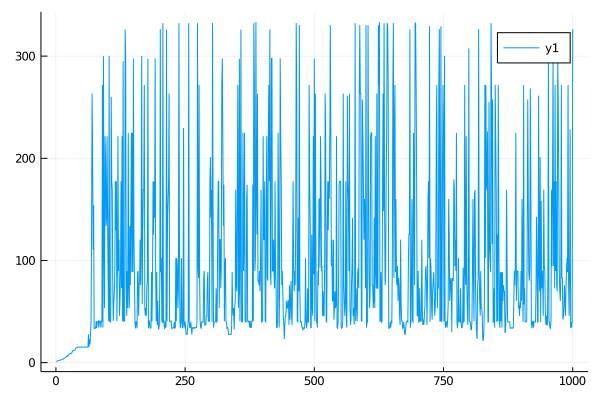

In [88]:
objective = evaluate_bird
Npop = 30
Ngen = 1000
sigma = 0.05
mu = 1

distances = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sigma, mu=mu )

plot(distances)

In [ ]:





#_____________________________CMA_ES_____________________________________





In [50]:
mutable struct CMAES
    N::Int
    μ::Int
    λ::Int
    τ::Float64
    τ_c::Float64
    τ_σ::Float64
    population::Array{Array{Float64}}
    offspring::Array{Array{Float64}}
    F_μ::Array{Float64}
    F_λ::Array{Float64}
    C::Array{Float64}
    s::Array{Float64}
    s_σ::Array{Float64}
    σ::Float64
    E::Array{Float64}
    W::Array{Float64}
    x::Array{Float64}
end

In [51]:
function CMAES(;N=N_value, μ=mu, λ=lambda, τ=sqrt(N), τ_c=N^2, τ_σ=sqrt(N))
    x = randn(N)
    population = fill(x, µ)
    offspring = Array{Array{Float64}}(undef, λ)
    F_µ = Inf .* ones(µ)
    F_λ = Inf .* ones(λ)
    C = Array(Diagonal{Float64}(I, N))
    s = zeros(N)
    s_σ = zeros(N)
    σ = 1.0
    E = zeros(N, λ)
    W = zeros(N, λ);
    CMAES(N, μ, λ, τ, τ_c, τ_σ, population, offspring, F_µ, F_λ, C, s, s_σ, σ, E, W, x)
end

CMAES

In [124]:
function step_cmaes!(c::CMAES; obj=objective)
    # L1
    sqrt_c = cholesky((c.C + c.C') / 2.0).U
    for i in 1:c.λ
        c.E[:,i] = randn(c.N)
        c.W[:,i] = c.σ * (sqrt_c * c.E[:,i])
        c.offspring[i] = c.x + c.W[:,i]
        c.F_λ[i] =  obj(c.offspring[i])
    end    
    # Select new parent population
    idx = sortperm(c.F_λ)[1:c.μ]
    for i in 1:c.μ
        c.population[i] = c.offspring[idx[i]]
        c.F_μ[i] = c.F_λ[idx[i]]
    end    
    # L2
    w = vec(mean(c.W[:,idx], dims=2))##################################################
    c.x += w
    # L3
    c.s = (1.0 - 1.0/c.τ)*c.s + (sqrt(c.μ/c.τ * (2.0 - 1.0/c.τ))/c.σ)*w   
    # L4
    c.C = (1.0 - 1.0/c.τ_c).*c.C + (c.s./c.τ_c)*c.s'    
    # L5
    ɛ = vec(mean(c.E[:,idx], dims=2))##################################################
    c.s_σ = (1.0 - 1.0/c.τ_σ)*c.s_σ + sqrt(c.μ/c.τ_σ*(2.0 - 1.0/c.τ_σ))*ɛ    
    # L6
    c.σ = c.σ*exp(((c.s_σ'*c.s_σ)[1] - c.N)/(2*c.N*sqrt(c.N)))
    
    if c.σ>1.0
        c.σ = 1.0
    end
    #if c.σ<0.0005
    #    c.σ = 0.0005
    #end
    
    c
end

step_cmaes! (generic function with 1 method)

In [125]:
function objective_cma(g::Array{Float64})
    -1*evaluate_bird(g)
end

N_value = 5
mu = 5
lambda = 10
c = CMAES()
println(c.population[1])
println(evaluate_bird(c.population[1]))
step_cmaes!(c, obj=objective_cma)
println(c.population[1])
println(evaluate_bird(c.population[1]))
step_cmaes!(c, obj=objective_cma)
println(c.population[1])
println(evaluate_bird(c.population[1]))
step_cmaes!(c, obj=objective_cma)
println(c.population[1])
println(evaluate_bird(c.population[1]))

[0.9550524119637221, 0.14954986794621175, -0.580022810800907, -0.5751381570158502, 0.8806685489373677]
1.0522265443275203
[1.3204457671773882, -1.0464794721989017, 0.03142775355513916, -1.8744156618616787, -0.5174593447056376]
2.7268857443275203
[0.8901605126360144, -1.7189211991117717, 1.0102264057098065, -1.5997887924746026, 0.04016080098021868]
17.380789955336017
[0.8496554853597497, -0.020851134289247675, 0.13678346924423987, -1.539792763067514, -0.23213843159684633]
6.966236144327522


In [126]:
function run_cmaes(;Nstep=500, mu=5, lambda=10)
    c = CMAES()
    sigs = zeros(Nstep)
    dist = zeros(Nstep)
    for i in 1:Nstep
        step_cmaes!(c,obj=objective_cma)
        sigs[i] = c.σ
        dist[i] = evaluate_bird(c.x)
    end
    [c.x, sigs, dist]
end
    

run_cmaes (generic function with 1 method)

Bird([-3.6900947562290134, -0.4028327734726142, -0.04176554659017216, -1.8375731004129021, -0.0013097813485704348], 332.3009971766702)


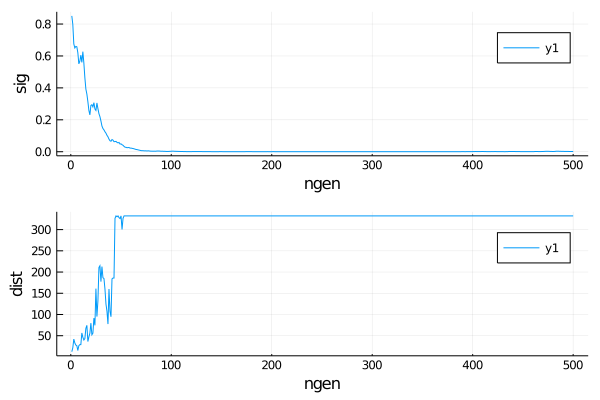

In [246]:
Nstep = 500
mu = 1
lambda = 50

flappy_boss = Bird()
res = run_cmaes(Nstep=Nstep, mu=mu, lambda=lambda)
flappy_boss.genes = res[1]
evaluate!(flappy_boss)
println(flappy_boss)

sigs = res[2]
p1 = plot(sigs)
xaxis!("ngen")
yaxis!("sig")

dist = res[3]
p2 = plot(dist)
xaxis!("ngen")
yaxis!("dist")

plot(p1, p2, layout=(2,1))

#Bird([-4.991793690362872, -1.0548510731723693, -0.46613776158659587, -2.281903602732939, -0.0011843804167953435], 332.30109957667014)

Bird[Bird([-15.191066627346242, -4.340143791602087, -3.1410138447063574, -4.807422988147851, -0.0007543823487974866], 266.32872549484193), Bird([-2.7630263141095552, -0.36725636647340426, 0.4745489817443048, -1.7729002299619736, -0.0038741152772750636], 185.96625957150133), Bird([-2.892028313456245, -0.5982647479709933, 0.6117385898475763, -1.7946282607025976, -0.0027584282179520486], 185.96631077150133), Bird([-6.151445215397052, -1.2054373026939227, -1.1073524847994853, -2.5536112591001117, -0.002079918263160124], 333.3974439773476), Bird([-5.647610358337427, -1.1694676939832014, -0.9300433445092087, -2.3734932616741964, -0.0006436786654238377], 333.3974439773476), Bird([-7.209416138807106, -2.2032359755187794, -0.6900209131619818, -3.4354643266493046, -0.0016952724447234974], 266.3289807832409), Bird([-4.0715383116122785, -0.5625496207271734, -0.27017891790262677, -2.1781103432741813, -0.002558595066680288], 332.3009971766702), Bird([-5.139841356618603, -1.981546808309948, 1.1377459

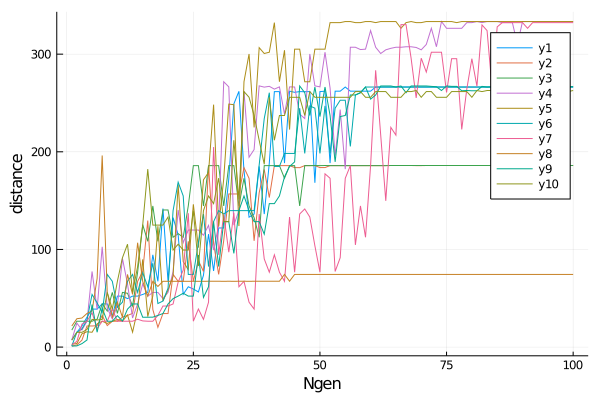

In [252]:
Nrun=10
Nstep = 100
mu=1
lambda= 50

distances = zeros(Nstep, Nrun)
birds = Array{Bird}(undef, Nrun)
for i in 1:Nrun
    res = run_cmaes(Nstep=Nstep, mu=mu, lambda=lambda)
    distances[:,i] = res[3]
    birds[i] = Bird()
    birds[i].genes = res[1]
    evaluate!(birds[i])
end

println(birds)
plot(distances)
xaxis!("Ngen")
yaxis!("distance")

In [ ]:
#_________SANDBOX_____________________

In [ ]:
pop = Array{Bird}(undef, 5)

for i in eachindex(pop)
    pop[i] = Bird()
    evaluate!(pop[i])
end
println(pop)

pop2 = sort(pop, rev=true)

In [225]:
N = ones(3,2)
println(N)
S = [5,10]
#println(N.*S)
#println(S.*N)
#println(dot(S,N))
#println(dot(N,S))
#res1 = [dot(N[:, i]) for i in 1:size(N, 2)]
#println("res1 ",res1)

res2 = reshape([N[i,:].*S for i in 1:3],3,2)
println("res2 ",res2)

x = [2.0,4.0]
P = repeat(x,1,3)
println(P')

println(P'.+N)
println(P'.+res2)

[1.0 1.0; 1.0 1.0; 1.0 1.0]


DimensionMismatch: DimensionMismatch("new dimensions (3, 2) must be consistent with array size 3")